In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

year = 2014

Preprocessing

In [356]:
df = pd.read_csv('datasets/shooting.csv')

df['CrimeDate'] = pd.to_datetime(df['CrimeDate'], format='%Y-%m-%d')
df = df[(df['CrimeDate'].dt.year >= year) & (df['CrimeDate'].dt.year <= year)]

print(len(df))
df.tail()

369


,Unnamed: 0,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,Total_Incidents
3087,562391,2014-08-31,03:35:00,9S,4200 BERGER AV,SHOOTING,Outside,FIREARM,444.0,NORTHEAST,FRANKFORD,39.339772,-76.546870,"(39.339772321516953,-76.546870296646574)",PUBLIC AREA,1
3088,562397,2014-08-31,04:30:00,9S,3300 EDMONDSON AV,SHOOTING,Outside,FIREARM,815.0,SOUTHWEST,EDGEWOOD,39.294227,-76.672833,"(39.294226826187398,-76.672832699748497)",STREET,1
3089,562400,2014-08-31,05:40:00,9S,3300 W BELVEDERE AV,SHOOTING,Outside,FIREARM,633.0,NORTHWEST,ARLINGTON,39.348459,-76.677283,"(39.348459009308662,-76.677283049686366)",STREET,1
3090,562413,2014-08-31,10:26:00,9S,1900 ST PAUL ST,SHOOTING,Outside,FIREARM,134.0,CENTRAL,CHARLES NORTH,39.311833,-76.615181,"(39.311833048119773,-76.615181105068658)",STREET,1
3091,562433,2014-08-31,14:22:00,9S,400 S AUGUSTA AV,SHOOTING,Outside,FIREARM,833.0,SOUTHWEST,IRVINGTON,39.279435,-76.684268,"(39.279435397137114,-76.68426829409384)",NaN,1


DBSCAN Clustering

In [357]:
location = df[['Latitude','Longitude']]

# Hapus data yang tidak memiliki koordinat
location = location.dropna()

# Hanya gunakan data yang berada di radius 39, -75 (Kota Baltimore) 
location = location.loc[(location['Latitude']>39) & (location['Longitude'] < -75)]  

In [358]:
print('=== Null ===')
print(location.isnull().sum())
print('=== Shape ===')
print(location.shape)

lenght = len(location)

=== Null ===
Latitude     0
Longitude    0
dtype: int64
=== Shape ===
(368, 2)


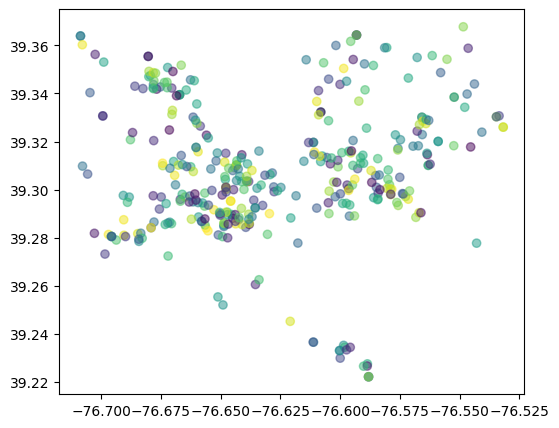

In [359]:
x = location['Longitude']
y = location['Latitude']

colors = np.random.rand(len(x))

plt.figure(figsize=(6,5))
plt.scatter(x, y,c=colors, alpha=0.5)
plt.show()

In [360]:
import folium
import re

m = folium.Map(location=[df.Latitude.median(), df.Longitude.median()], zoom_start=12, 
               tiles='OpenStreet Map')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.Latitude, row.Longitude],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.Location),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)
    
m

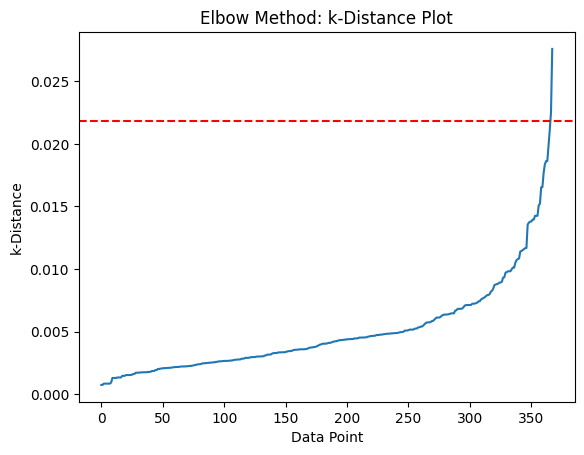

Nilai epsilon yang disarankan: 0.0218


In [361]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Data
XD = location
XD = XD[~np.isnan(XD)]
X = XD.dropna()

# K-Distance = 2x(Jumlah Dimensi)
nn = NearestNeighbors(n_neighbors=4)
nn.fit(X)
distances, _ = nn.kneighbors(X)

# Sorting distances
distances = np.sort(distances, axis=0)
distances = distances[:, -1]

# Plot k-distance
plt.plot(distances)

# Mencari perubahan yang signifikan dalam k-distance
differences = np.diff(distances)
max_diff = np.argmax(differences) + 1

# Menentukan epsilon
epsilon = 0.0218
plt.axhline(y=epsilon, color='r', linestyle='--')

plt.xlabel('Data Point')
plt.ylabel('k-Distance')
plt.title('Elbow Method: k-Distance Plot')
plt.show()

print("Nilai epsilon yang disarankan:", epsilon)


In [366]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

X = df[['Latitude', 'Longitude']] # [39.359472 -76.587312, 39.305210 -76.599508]
X = X.dropna()

db = DBSCAN(eps=0.005, min_samples=5).fit(X)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('======')
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 14
Estimated number of noise points: 111
Silhouette Coefficient: -0.004


In [363]:
# Membuat y_pred secara otomatis dengan lokasi koordinat di sekitar X
random_range = 0.001  # Rentang acak di sekitar setiap titik X
y_pred = np.zeros(len(X))

for i, (lat, lon) in enumerate(X.values):
    lat_random = np.random.uniform(lat - random_range, lat + random_range)
    lon_random = np.random.uniform(lon - random_range, lon + random_range)
    y_pred[i] = np.random.choice(labels)

completeness = metrics.completeness_score(y_pred, labels)
homogeneity = metrics.homogeneity_score(y_pred, labels)
v_measure = metrics.v_measure_score(y_pred, labels)
adjusted_rand_index = metrics.adjusted_rand_score(y_pred, labels)
adjusted_mutual_info = metrics.adjusted_mutual_info_score(y_pred, labels)
precision = metrics.precision_score(y_pred, labels, average='micro')

print("Completeness: %0.3f" % completeness)
print("Homogeneity: %0.3f" % homogeneity)
print("V-measure: %0.3f" % v_measure)
print("Adjusted Rand Index: %0.3f" % adjusted_rand_index)
print("Adjusted Mutual Information: %0.3f" % adjusted_mutual_info)
print("Precision Score: %0.3f" % precision)

Completeness: 0.000
Homogeneity: 0.001
V-measure: 0.001
Adjusted Rand Index: -0.004
Adjusted Mutual Information: -0.003
Precision Score: 0.992
